In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, LSTM, Reshape
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import os
import shap
import matplotlib.pyplot as plt

C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
data_path = 'Dataset'
try:
    all_files = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith('.csv')]
    df = pd.concat((pd.read_csv(f, on_bad_lines='skip') for f in all_files), ignore_index=True)
except FileNotFoundError:
    print("Directory not found...")    

In [4]:
df.shape

(2830743, 79)

In [5]:
df.columns = df.columns.str.strip()
df.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [6]:
df.dropna(inplace=True)
df.shape

(2829385, 79)

In [7]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.shape

(2827876, 79)

In [8]:
df.drop_duplicates(inplace=True)
df.shape

(2520798, 79)

In [9]:
x = df.drop(columns=['Label'])
y = df['Label']

In [10]:
feature_names = x.columns

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

ss = StandardScaler()
x_scaled = ss.fit_transform(x)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(
    x_scaled, 
    y_categorical, 
    test_size=0.2, 
    random_state=42,
    stratify=y_categorical
)

# reshape data for CNN, LSTM [samples, timestep, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

x_train.shape

(2016638, 1, 78)

In [19]:
CHECKPOINT_DIR = 'Model'
CHECKPOINT_FILE = os.path.join(CHECKPOINT_DIR, 'best_model.keras')
batch_size = 256
total_epoch = 20

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
initial_epoch = 0

if os.path.exists(CHECKPOINT_FILE):
    print(f"\nLoading model from checkpoint: {CHECKPOINT_FILE}")
    model = load_model(CHECKPOINT_FILE)
else:
    print("No checkpoint found")
    # model
    model = Sequential()
    # CNN layer
    model.add(Conv1D(filters=64, 
                     kernel_size=1, 
                     activation='relu',
                     input_shape=(x_train.shape[1], x_train.shape[2])
                    ))
    model.add(MaxPooling1D(pool_size=1))
    # LSTM layer
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.5))
    # dense layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
model.summary()

No checkpoint found
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 64)             5056      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                  

In [16]:
early_stoping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

best_checkpoint_path = os.path.join(CHECKPOINT_DIR, 'best_model.keras')
model_checkpoint = ModelCheckpoint(
    best_checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=total_epoch,
    batch_size=batch_size,
    callbacks=[early_stoping, model_checkpoint],
    verbose=1,
    initial_epoch=initial_epoch
)

Epoch 1/20
6301/6302 [============================>.] - ETA: 0s - loss: 0.0902 - accuracy: 0.9701
Epoch 1: val_loss improved from inf to 0.05058, saving model to checkpoints\best_model.keras
6302/6302 [==============================] - 51s 8ms/step - loss: 0.0902 - accuracy: 0.9701 - val_loss: 0.0506 - val_accuracy: 0.9793
Epoch 2/20
6295/6302 [============================>.] - ETA: 0s - loss: 0.0495 - accuracy: 0.9796
Epoch 2: val_loss improved from 0.05058 to 0.04333, saving model to checkpoints\best_model.keras
6302/6302 [==============================] - 48s 8ms/step - loss: 0.0495 - accuracy: 0.9796 - val_loss: 0.0433 - val_accuracy: 0.9828
Epoch 3/20
6297/6302 [============================>.] - ETA: 0s - loss: 0.0435 - accuracy: 0.9820
Epoch 3: val_loss improved from 0.04333 to 0.03674, saving model to checkpoints\best_model.keras
6302/6302 [==============================] - 49s 8ms/step - loss: 0.0435 - accuracy: 0.9820 - val_loss: 0.0367 - val_accuracy: 0.9836
Epoch 4/20
6297/6

In [17]:
print("\nEvaluating the model on the test set...")
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Evaluating the model on the test set...
15755/15755 [==============================] - 71s 5ms/step - loss: 0.0176 - accuracy: 0.9946

Test Loss: 0.0176
Test Accuracy: 0.9946



--- Explainable AI (XAI) with SHAP ---
Calculating SHAP values... This may take a moment.
4/4 [==============================] - 0s 10ms/step


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

6813/6813 [==============================] - 14s 2ms/step


 10%|████████▎                                                                          | 1/10 [00:18<02:48, 18.73s/it]

6813/6813 [==============================] - 14s 2ms/step


 20%|████████████████▌                                                                  | 2/10 [00:35<02:20, 17.57s/it]

6813/6813 [==============================] - 14s 2ms/step


 30%|████████████████████████▉                                                          | 3/10 [00:52<01:59, 17.13s/it]

6813/6813 [==============================] - 14s 2ms/step


 40%|█████████████████████████████████▏                                                 | 4/10 [01:08<01:40, 16.80s/it]

6813/6813 [==============================] - 15s 2ms/step


 50%|█████████████████████████████████████████▌                                         | 5/10 [01:26<01:25, 17.18s/it]

6813/6813 [==============================] - 15s 2ms/step


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [01:44<01:10, 17.60s/it]

6813/6813 [==============================] - 16s 2ms/step


 70%|██████████████████████████████████████████████████████████                         | 7/10 [02:03<00:54, 18.09s/it]

6813/6813 [==============================] - 17s 2ms/step


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [02:24<00:37, 18.99s/it]

6813/6813 [==============================] - 17s 2ms/step


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [02:45<00:19, 19.60s/it]

6813/6813 [==============================] - 15s 2ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:04<00:00, 18.43s/it]


SHAP values calculated. Generating summary plot.


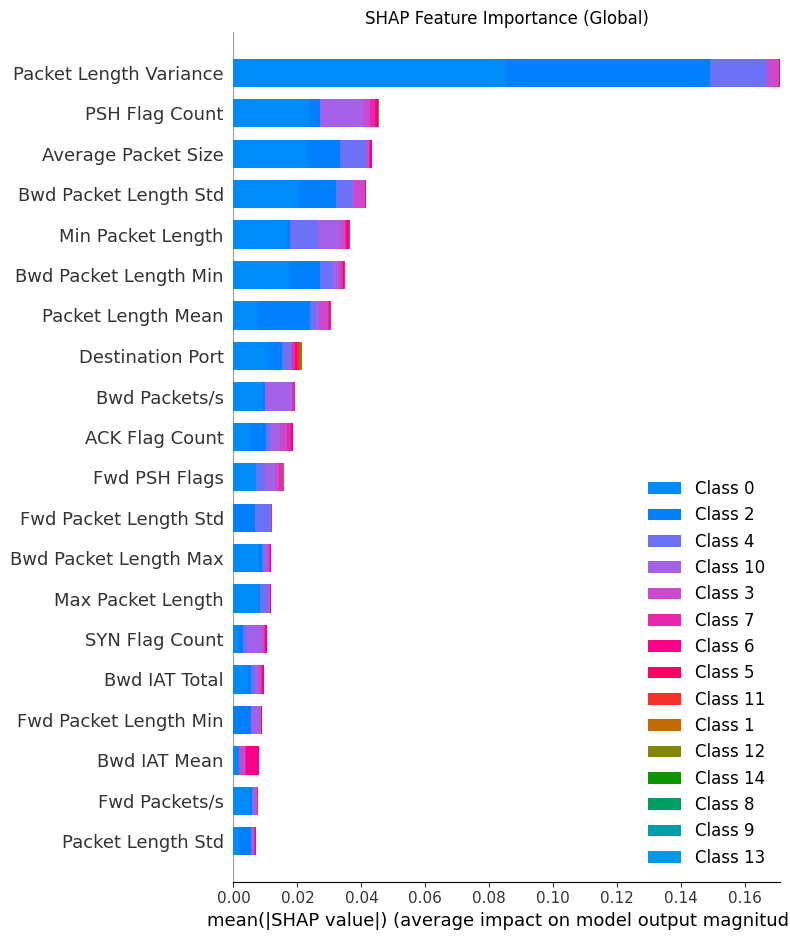

In [18]:
# Implement Explainable AI (XAI) with SHAP ---
print("\n--- Explainable AI (XAI) with SHAP ---")
print("Calculating SHAP values... This may take a moment.")

x_test_2d = np.reshape(x_test, (x_test.shape[0], x_test.shape[2]))
explainer_data = x_test_2d[:100]

def predict_fn(x):
    x_reshaped = np.reshape(x, (x.shape[0], 1, x.shape[1]))
    return model.predict(x_reshaped)

# Create a SHAP explainer object using the new wrapper function
explainer = shap.KernelExplainer(predict_fn, explainer_data)

# Calculate SHAP values for a few test samples
shap_values = explainer.shap_values(x_test_2d[:10])

print("SHAP values calculated. Generating summary plot.")

# Generate the SHAP summary plot
shap.summary_plot(shap_values, x_test_2d[:10], feature_names=feature_names, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Global)")
plt.tight_layout()
plt.show()